NOTE:- This notebook is a derivative of the LSTM only version notebook.

## Importing relevant modules

In [ ]:
!pip install transformers

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import json
import transformers
from transformers import BertModel, BertTokenizer

We will be using the BertModel and BertTokenizer to obtain the word embeddings. There are other ways to do this but this is a bit easier in my opinion.

## Reading the dataset
The dataset in [Kaggle](https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection) is in the form of json files. So, first we convert that to csv. The commented out code block does this.

In [ ]:
# try:
#     df = pd.read_json('Sarcasm_Headlines_Dataset.json', encoding='utf-8')
#     df.to_csv('sarcasm_headlines.csv', encoding='utf-8', index=False)
# except ValueError as e:
#     print(f"ValueError: {e}")

# # Option 2: Read JSON file line by line and then convert
# try:
#     with open('Sarcasm_Headlines_Dataset.json', 'r', encoding='utf-8') as inputfile:
#         data = [json.loads(line) for line in inputfile]
#     df = pd.DataFrame(data)
#     df.to_csv('sarcasm_headlines.csv', encoding='utf-8', index=False)
# except ValueError as e:
#     print(f"ValueError: {e}")

In [ ]:
df = pd.read_csv("sarcasm_headlines.csv")
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


Now, we will check to which sites, the articles belong

## Data pre-processing

In this section, we will try to observe patterns in the data and extract good features (if any).

In [ ]:
domain_name = []

for i in df['article_link']:
    domain_name.append(i.split('/')[2])

df.insert(2, 'domain_name', domain_name)
df.head(5)

,article_link,headline,domain_name,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,www.huffingtonpost.com,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,www.huffingtonpost.com,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,local.theonion.com,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",politics.theonion.com,1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,www.huffingtonpost.com,0


In [ ]:
df['domain_name'] = df['domain_name'].replace({'www.huffingtonpost.comhttp:': 'www.huffingtonpost.com', 'www.huffingtonpost.comhttps:': 'www.huffingtonpost.com'})
df['domain_name'].unique()

array(['www.huffingtonpost.com', 'local.theonion.com',
       'politics.theonion.com', 'entertainment.theonion.com',
       'www.theonion.com', 'sports.theonion.com'], dtype=object)

Even though there are 6 unique domain names, all the articles can be classified either as a huffingtonpost article or the onion article

In [ ]:
df['domain_name'] = df['domain_name'].replace({
    'local.theonion.com': 'theonion',
    'politics.theonion.com': 'theonion',
    'entertainment.theonion.com': 'theonion',
    'sports.theonion.com': 'theonion',
    'www.theonion.com': 'theonion',
    'www.huffingtonpost.com': 'huffingtonpost'
})

df['domain_name'].unique()

array(['huffingtonpost', 'theonion'], dtype=object)

We will drop the article link since we got the domain name. The headline will give us more than enough information.

In [ ]:
df.drop('article_link', axis = 1, inplace = True)

We will observe the correlation between the domain name and the article's measure of sarcasm.

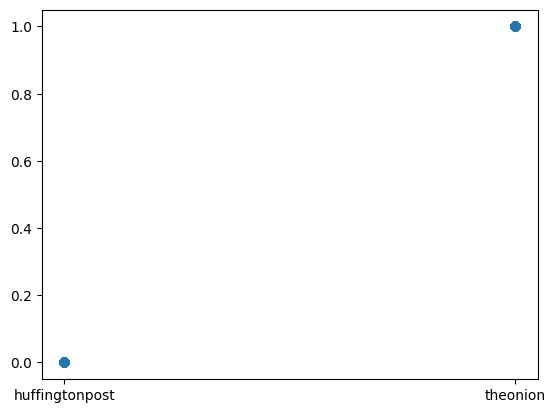

In [ ]:
plt.scatter(df['domain_name'], df['is_sarcastic'])
plt.show()

We can observe that all the huffingtonpost articles are non-sarcastic and all theonion articles are sarcastic (which aligns with what was mentioned in the Kaggle site). So, technically we can achieve 100% accuracy without even using an LSTM. But where is the fun in that?

Moreover what we are trying to do is to build a model that is able to sense sarcasm irrespective of the content being theonion article or the huffingtonpost article.

Let us check for any duplicate entries and remove them.

In [ ]:
len(df['headline'].unique()) == len(df['headline'])

False

In [ ]:
df[df.duplicated(subset=['headline'], keep=False)]

,headline,domain_name,is_sarcastic
182,magic-markered initials fail to deter breakroo...,theonion,1
533,antarctic observational comic running out of i...,theonion,1
1019,the best chance to defeat roy moore may be for...,huffingtonpost,0
1091,antarctic observational comic running out of i...,theonion,1
1131,pier 1 issues formal apology for rattan death ...,theonion,1
...,...,...,...
26121,"'no way to prevent this,' says only nation whe...",theonion,1
26156,"area man busts his ass all day, and for what?",theonion,1
26353,kleenex box inadequately covered,theonion,1
26500,candy purchase puts yet more money in raisinet...,theonion,1


In [ ]:
df = df.drop_duplicates(subset=['headline'])

## Building the Dataset and the Model

First, we declare the device.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Then, we intialize the Bert Model and Tokenizer that we will use to extract the word embeddings.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased").to(device)

These are some standard variable and hyperparameters which will come into use as we will see.

In [ ]:
MAX_LEN = 128
LEARNING_RATE = 3e-05
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 8
EPOCHS = 3

Then, we construct our CustomDataset class which would handle our embedding generation and the batching of training examples.

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, df, max_len, tokenizer, model, device):
        self.data = df
        self.text = self.data.headline
        self.targets = self.data.is_sarcastic
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.model = model
        self.device = device

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        text = str(self.text[idx])

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        input_ids = inputs['input_ids'].squeeze(0).to(self.device)  # Move to device
        attention_mask = inputs['attention_mask'].squeeze(0).to(self.device)  # Move to device

        with torch.no_grad():
            outputs = self.model(input_ids=input_ids.unsqueeze(0), attention_mask=attention_mask.unsqueeze(0))

        embedding = outputs.last_hidden_state.squeeze(0).to(self.device)  # Move to device

        return {
            "embedding": embedding,
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "targets": torch.tensor(self.targets[idx], dtype=torch.float).to(self.device)  # Move to device
        }

We split the dataset into training and testing.

In [ ]:
train_size = 0.8
train_dataset = df.sample(frac=train_size, random_state=42)
test_dataset = df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

In [ ]:
training_set = CustomDataset(train_dataset, MAX_LEN, tokenizer=tokenizer, model=model, device=device)
testing_set = CustomDataset(test_dataset, MAX_LEN, tokenizer=tokenizer, model=model,device=device)

In [ ]:
training_loader = DataLoader(training_set, batch_size=TRAIN_BATCH_SIZE, shuffle = True)
test_loader = DataLoader(testing_set, batch_size=VALID_BATCH_SIZE, shuffle=True)

Our model is going to consist of a stacked bi-directional LSTM. The parameters like dropout of the LSTM and its hidden size can be experimented on. These are the values I found worked the best. (In all honesty, there could be better values for the parameter, but I don't think that will affect the model significantly.)

In [ ]:
class CustomModel(nn.Module):
    def __init__(self, hidden_size, input_size):
        super(CustomModel, self).__init__()
        self.layer0 = BertModel.from_pretrained("bert-base-uncased")
        self.hidden_size = self.layer0.config.hidden_size
        self.layer1 = nn.LSTM(input_size=self.hidden_size, hidden_size=self.hidden_size, num_layers=2, dropout=0.2, bidirectional=True)
        #self.dropout = nn.Dropout(0.3)   #From my observations, I don't think the dropout layer improves the model's performance
        self.layer2 = nn.Linear(self.hidden_size*2, 1)
        self.layer3 = nn.Sigmoid()

    def forward(self, embed, input_ids, attention_mask):
        output = self.layer0(input_ids=input_ids, attention_mask = attention_mask).last_hidden_state
        output = output.permute(1, 0, 2)
        output, (h_n, c_n) = self.layer1(output)
        output = output[-1]
        #output = self.dropout(output)
        return self.layer3(self.layer2(output)).view(-1)

In [ ]:
SeqModel = CustomModel(256, 768)
SeqModel.to(device)

CustomModel(
  (layer0): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise

## The Training and Testing Process

Just a little sidenote. Since, I am still a beginner, one mistake that I made was to use BCEWithLogitsLoss() instead of BCELoss() as the loss function. As the model didn't learn very well, I realised my mistake and used the correct function. This [StackOverflow](https://stackoverflow.com/questions/75979632/pytorchs-nn-bcewithlogitsloss-behaves-totaly-differently-than-nn-bceloss) post explains the difference.

In [ ]:
optimizer = torch.optim.AdamW(params=SeqModel.parameters(), lr=LEARNING_RATE)
lossfn = nn.BCELoss()

In [ ]:
losses = []

def training(train_loader, modl, epoch):
    modl.train()
    total_loss = 0

    for i, batch in enumerate(train_loader):
        embed = batch['embedding'].to(device)
        target = batch['targets'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        preds = modl(embed, input_ids, attention_mask)
        preds = preds.squeeze(-1)
        loss = lossfn(preds, target)

        total_loss += loss.item()
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
          print(f"Epoch: {epoch}, loss: {loss:.4f}")

    avg_loss = total_loss / len(train_loader)
    print(f"Average training loss: {avg_loss:.4f}")

In [ ]:
for epoch in range(EPOCHS):
  training(training_loader, SeqModel, epoch)

Epoch: 0, loss: 0.6918
Epoch: 0, loss: 0.2375
Epoch: 0, loss: 0.1323
Epoch: 0, loss: 0.3837
Epoch: 0, loss: 0.0744
Epoch: 0, loss: 0.1763
Epoch: 0, loss: 0.2177
Average training loss: 0.2602
Epoch: 1, loss: 0.2296
Epoch: 1, loss: 0.0327
Epoch: 1, loss: 0.0917
Epoch: 1, loss: 0.1633
Epoch: 1, loss: 0.1292
Epoch: 1, loss: 0.0376
Epoch: 1, loss: 0.0313
Average training loss: 0.1008
Epoch: 2, loss: 0.0238
Epoch: 2, loss: 0.0154
Epoch: 2, loss: 0.0040
Epoch: 2, loss: 0.0107
Epoch: 2, loss: 0.0073
Epoch: 2, loss: 0.2866
Epoch: 2, loss: 0.0130
Average training loss: 0.0408
Epoch: 3, loss: 0.0317


KeyboardInterrupt: 

Let us plot the training curve. NOTE: The training curve when plotted all the losses just looked like a mess hence I am taking in the interval of 500 examples

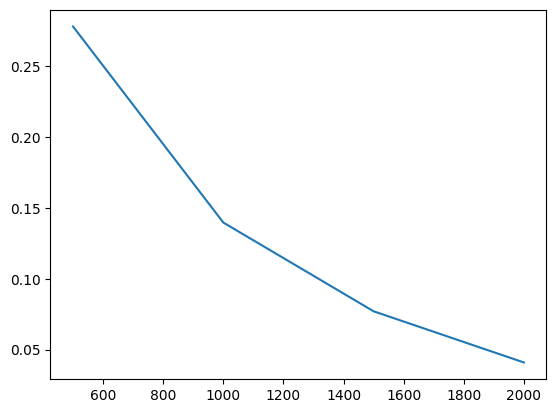

In [ ]:
lst = [(i, sum(losses[i-500:i])/500) for i in range(1, len(losses)) if i % 500 == 0]
plt.plot([i for (i, j) in lst], [j for (i, j) in lst])
#plt.plot([i for i in range(len(losses))], losses)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
def testing(test_loader, modl):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in test_loader:
            embeddings = batch['embedding'].to(device)
            labels = batch['targets'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            input_ids = batch['input_ids'].to(device)

            outputs = modl(embeddings, input_ids, attention_mask)
            outputs = outputs.squeeze(-1)

            preds = (outputs > 0.5).float()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    return all_labels, all_preds

In [ ]:
all_labels, all_preds = testing(test_loader, SeqModel)

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9289
Precision: 0.9225
Recall: 0.9112
F1 Score: 0.9168


These are pretty good metrics overall. In the following sections, we will delve into the theoretical aspects of LSTMs.